# Lab 9-6: MNIST Batch normalization - 배치 정규화

In [8]:
#import
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#for reproducibility
torch.manual_seed(1)
if device =='cuda':
  torch.cuda.manual_seed_all(1)

In [9]:
#parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

#MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                         train=True,
                         transform= transforms.ToTensor(),
                         download= True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform= transforms.ToTensor(),
                         download= True)

#dataset loader
train_loader = torch.utils.data.DataLoader(dataset= mnist_train,
                                          batch_size= batch_size,
                                          shuffle=True,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset= mnist_test,
                                          batch_size= batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [10]:
#nn layers
linear1 = torch.nn.Linear(784, 32, bias= True)
linear2 = torch.nn.Linear(32, 32, bias= True)
linear3 = torch.nn.Linear(32, 10, bias= True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias= True)
nn_linear2 = torch.nn.Linear(32, 32, bias= True)
nn_linear3 = torch.nn.Linear(32, 10, bias= True)

#model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                               linear2, bn2, relu,
                               linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

#cost & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device) #Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr= learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr= learning_rate)

In [11]:
#save losses and accuracies every epoch
#we are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
  bn_model.train()

  for X, Y in train_loader:
    X = X.view(-1, 28*28).to(device)
    Y = Y.to(device)

    bn_optimizer.zero_grad()
    bn_prediction = bn_model(X)
    bn_loss = criterion(bn_prediction, Y)
    bn_loss.backward()
    bn_optimizer.step()

    nn_optimizer.zero_grad()
    nn_prediction = nn_model(X)
    nn_loss = criterion(nn_prediction, Y)
    nn_loss.backward()
    nn_optimizer.step()

  with torch.no_grad():
    bn_model.eval()

    # Test the model using **train** sets
    bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    for i, (X, Y) in enumerate(train_loader):
      X = X.view(-1, 28* 28).to(device)
      Y = Y.to(device)

      bn_prediction = bn_model(X)
      bn_correct_prediction = bn_prediction.argmax(1) == Y
      bn_loss += criterion(bn_prediction, Y)
      bn_acc += bn_correct_prediction.float().mean()
      
      nn_prediction = nn_model(X)
      nn_correct_prediction = nn_prediction.argmax(1) == Y
      nn_loss += criterion(nn_prediction, Y)
      nn_acc += nn_correct_prediction.float().mean()

    bn_loss, bn_acc = bn_loss / train_total_batch, bn_acc / train_total_batch
    nn_loss, nn_acc = nn_loss / train_total_batch, nn_acc / train_total_batch

    # save train losses/acc
    train_losses.append([bn_loss, nn_loss])
    train_accs.append([bn_acc, nn_acc])
    print(
      '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
      (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
    
    # Test the model using test sets
    bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    for i, (X, Y) in enumerate(test_loader):
      X = X.view(-1, 28*28).to(device)
      Y = Y.to(device)

      bn_prediction = bn_model(X)
      bn_correct_prediction = bn_prediction.argmax(1) == Y
      bn_loss += criterion(bn_prediction, Y)
      bn_acc += bn_correct_prediction.float().mean()
      
      nn_prediction = nn_model(X)
      nn_correct_prediction = nn_prediction.argmax(1) == Y
      nn_loss += criterion(nn_prediction, Y)
      nn_acc += nn_correct_prediction.float().mean()

    bn_loss, bn_acc = bn_loss / test_total_batch, bn_acc / test_total_batch
    nn_loss, nn_acc = nn_loss / test_total_batch, nn_acc / test_total_batch

    # save valid losses/acc
    valid_losses.append([bn_loss, nn_loss])
    valid_accs.append([bn_acc, nn_acc])
    print(
      '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
      (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
    print()
  print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.13576(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18107(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.14836(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.19673(nn_acc:0.94)

Learning finished
[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10767(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19113(nn_acc:0.94)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12157(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.22550(nn_acc:0.94)

Learning finished
[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.08463(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.16227(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11122(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.20881(nn_acc:0.95)

Learning finished
[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07604(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14984(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09950(bn_acc:0.97) vs No Batchnorm Loss(Ac

## VISUALIZATION

In [12]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

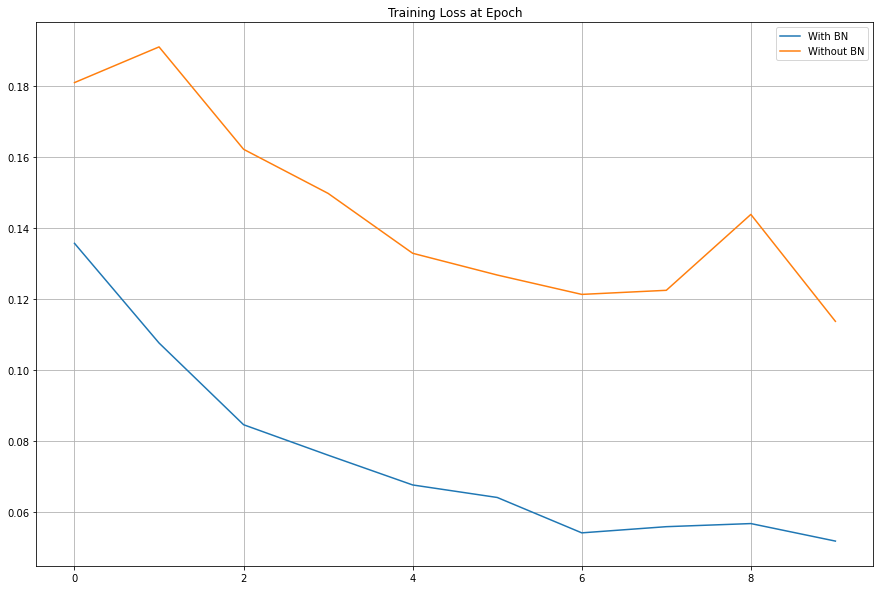

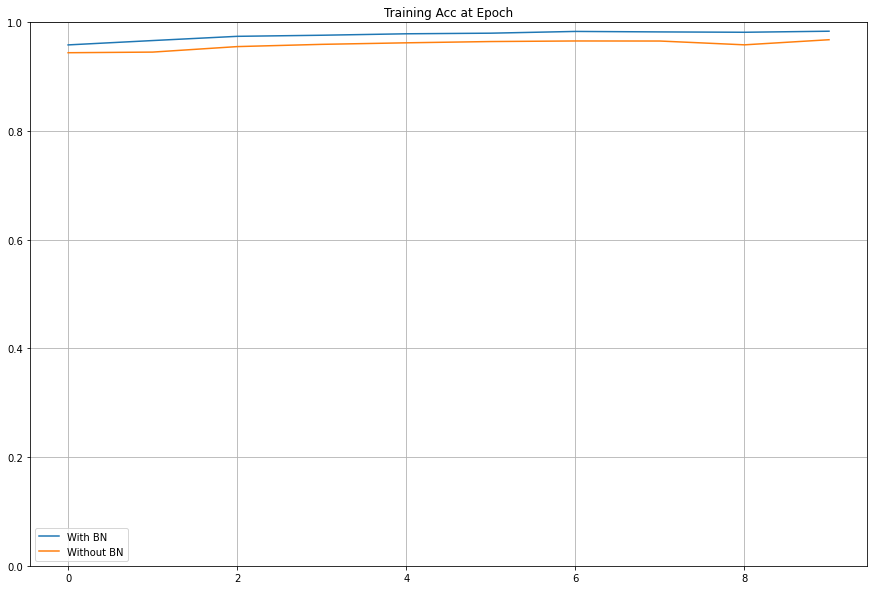

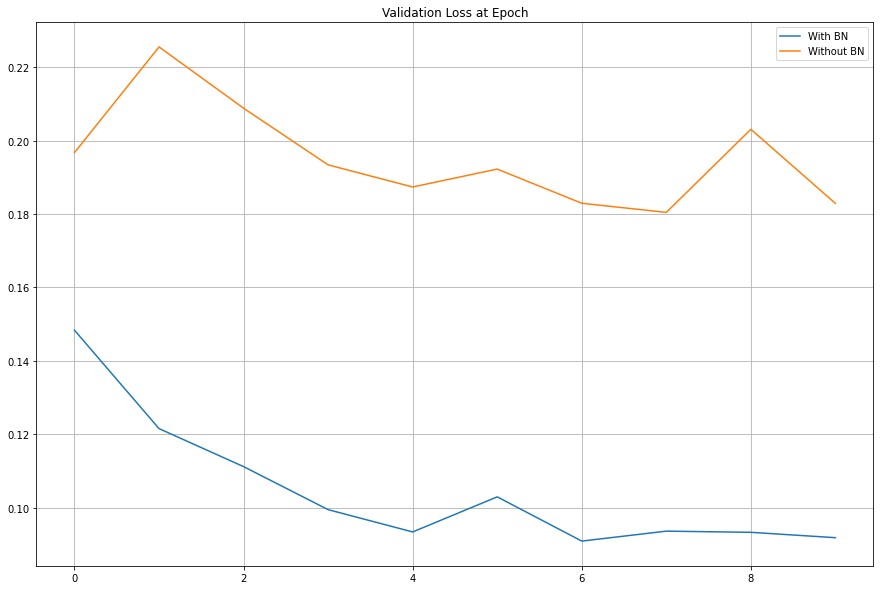

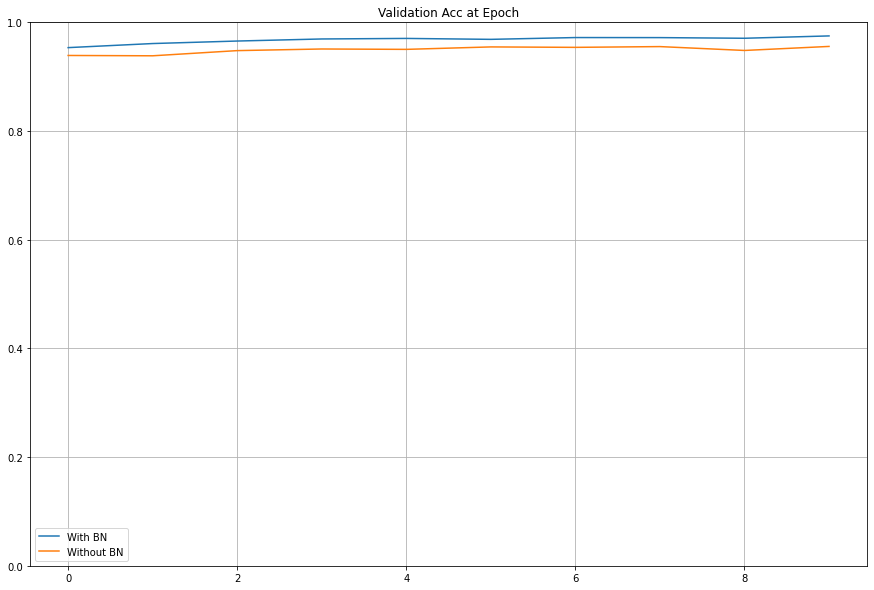

In [13]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')